# MNIST Digit Recognizer Starter Notebook

In this notebook, we will analyze the MNIST dataset of handwritten digits and classify each image as a digit from 0-9. We will use deep learning specifically a convolutional neural network. Our goal is to get the correct label on as many images as possible.

Dataset: The MNIST (Modified National Institute of Standards and Technology) dataset is a collection of images that are 28x28px (784px each image). Each pixel in an image is a number from 0-255 indicating the intensity of the pixel. Each image sample can be though of as a row vector of 785 values, where the first value is the label and the rest are the pixels of the image.

Submission file: Our submission will be a .csv file in which the first row is the headers ImageID, Label. For each subsequent line, the first number will be the image ID, followed by a comma and then our predicted label.

ImageID, Label  
1,8  
2,6  
...

# Import required packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

# Preview our data

In [2]:
FILE_PATH = '/kaggle/input/digit-recognizer/'

In [3]:
train_data_all = pd.read_csv(FILE_PATH + 'train.csv')
test_data_all = pd.read_csv(FILE_PATH + 'test.csv')

print(train_data_all.shape, test_data_all.shape)

(42000, 785) (28000, 784)


In [4]:
train_data_all.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
test_data_all.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Let us preview our labels.

In [6]:
print('List of unique labels: ' + str(sorted(train_data_all['label'].unique())))
print('Counts of unique labels:')
train_data_all['label'].value_counts().sort_index()

List of unique labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Counts of unique labels:


0    4132
1    4684
2    4177
3    4351
4    4072
5    3795
6    4137
7    4401
8    4063
9    4188
Name: label, dtype: int64

It looks like we have a good distribution of image samples for each of the labels. Now let us prepare our training data by separating the images and the labels.

In [7]:
x = train_data_all.drop("label", axis = 1)
y = train_data_all["label"]

print(x.shape)
print(y.shape)

print(type(x), type(y))

(42000, 784)
(42000,)
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>


Now we will use Scikit Learn's train_test_split function to separate our training set into training and validation sets. 

In [8]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.3, random_state = 1)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(29400, 784) (29400,)
(12600, 784) (12600,)


Now we will turn our data into numpy arrays and reshape them into images of 28x28 so that they can be fed to our model.

In [9]:
x_train_reshaped = np.array(x_train).astype('float64').reshape(-1, 28, 28, 1)
x_val_reshaped = np.array(x_val).astype('float64').reshape(-1, 28, 28, 1)

print(x_train_reshaped.shape)
print(x_val_reshaped.shape)

print(x_train_reshaped[0].dtype)
print(x_val_reshaped[0].dtype)

(29400, 28, 28, 1)
(12600, 28, 28, 1)
float64
float64


Let us peak at what our images look like using MatPlotLib.

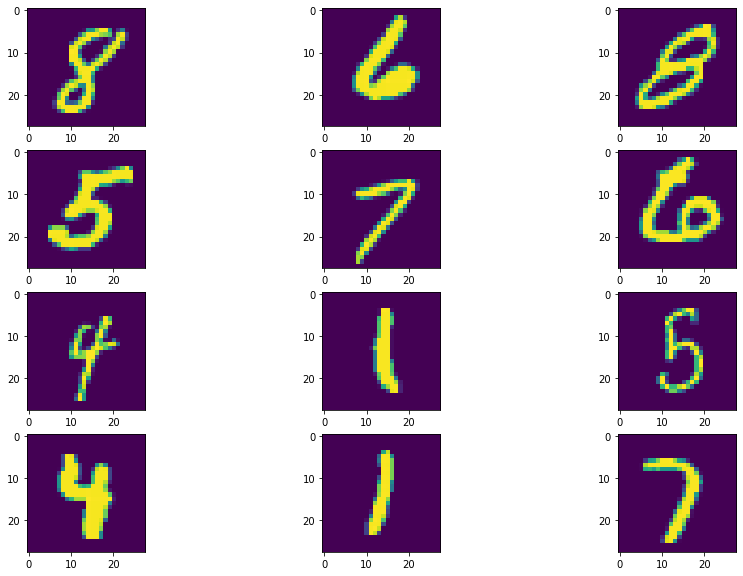

In [10]:
fig = plt.figure(figsize = (15, 10))

for i in range(12):
    plt.subplot(4, 3, i+1)
    plt.imshow(x_train_reshaped[i])

plt.show()

Before we send our data to the model, we will normalize it. Normalization of data can be thought of as shrinking all of our features (in this case pixels) proportionally so that they fall in between a certain range, often times with a mean of 0 and standard deviation of 1. This will help prevent our model from generating weight values that are too far apart and also help our model converge during training (gradient descent). Here, we will simply divide our pixel values by 255, which is the maximum intensity for a pixel.

In [11]:
x_train_reshaped = x_train_reshaped / 255.0
x_val_reshaped = x_val_reshaped / 255.0

x_train_reshaped[0].shape

(28, 28, 1)

Now, we will build our model. We will develop our ConvNet with the Tensorflow and Keras packages.

In [12]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, Flatten, BatchNormalization

In [13]:
model = Sequential()

model.add(Conv2D(64, kernel_size = 3, activation = "relu", padding="same", input_shape = (28, 28, 1)))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size = 3, activation = "relu"))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size = 5, strides=2, activation = "relu", padding="same"))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(64, kernel_size = 3, activation = "relu"))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size = 3, activation = "relu"))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size = 5, strides=2, activation = "relu", padding="same"))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(64, kernel_size = 4, activation = "relu"))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dropout(0.3))

model.add(Dense(units = 10, activation = "softmax"))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 64)        102464    
_________________________________________________________________
batch_normalization_2 (Batch (None, 13, 13, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 64)        0

# Visualization of our ConvNet architecture.

Keras has built in tools to help us visualize our models.

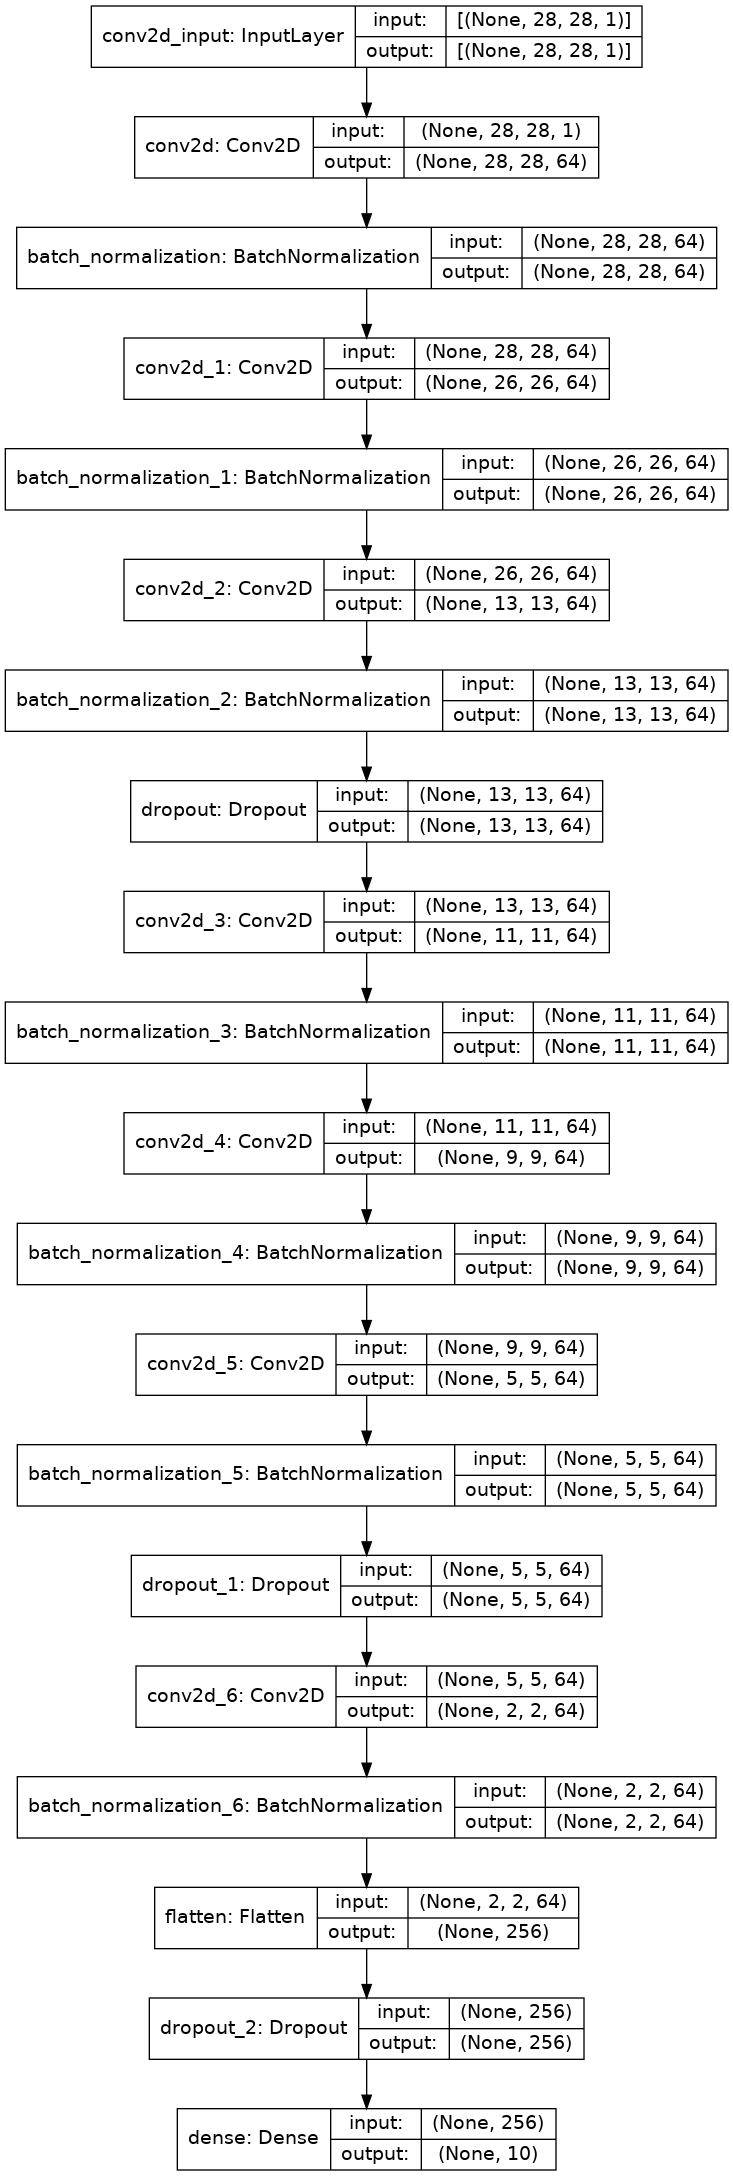

In [15]:
from keras.utils import plot_model
from IPython.display import Image

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
Image("model.png")

# Compiling and training our model

In [16]:
model.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

Reduce learning rate when a particular metric has stopped improving.(https://keras.io/api/callbacks/reduce_lr_on_plateau/)

In [17]:
from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5,
                              patience=2, min_lr=0.00001)

Learning rate scheduler. https://keras.io/api/callbacks/learning_rate_scheduler/

In [18]:
from tensorflow.keras.callbacks import LearningRateScheduler

callback = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

We are using the ImageDataGenerator class provided by Keras to augment our dataset. https://keras.io/api/preprocessing/image/

In [19]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=10,
        zoom_range = 0.1,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=False,
        vertical_flip=False)

datagen.fit(x_train_reshaped)

Now we will train our model using the fit method. The history object contains data about the training process.

In [20]:
history = model.fit(datagen.flow(x_train_reshaped,y_train, batch_size=64),
                         epochs=50, validation_data=(x_val_reshaped,y_val),
                         callbacks=[reduce_lr, callback],
                         verbose=2, steps_per_epoch=x_train_reshaped.shape[0] // 64)

Epoch 1/50
459/459 - 24s - loss: 0.8517 - accuracy: 0.7311 - val_loss: 6.8920 - val_accuracy: 0.1467
Epoch 2/50
459/459 - 19s - loss: 0.2085 - accuracy: 0.9369 - val_loss: 0.0877 - val_accuracy: 0.9742
Epoch 3/50
459/459 - 19s - loss: 0.1396 - accuracy: 0.9580 - val_loss: 0.0650 - val_accuracy: 0.9817
Epoch 4/50
459/459 - 19s - loss: 0.1114 - accuracy: 0.9663 - val_loss: 0.0698 - val_accuracy: 0.9793
Epoch 5/50
459/459 - 19s - loss: 0.0912 - accuracy: 0.9723 - val_loss: 0.0488 - val_accuracy: 0.9860
Epoch 6/50
459/459 - 19s - loss: 0.0798 - accuracy: 0.9761 - val_loss: 0.0450 - val_accuracy: 0.9886
Epoch 7/50
459/459 - 19s - loss: 0.0742 - accuracy: 0.9786 - val_loss: 0.0426 - val_accuracy: 0.9879
Epoch 8/50
459/459 - 19s - loss: 0.0685 - accuracy: 0.9798 - val_loss: 0.0399 - val_accuracy: 0.9891
Epoch 9/50
459/459 - 19s - loss: 0.0632 - accuracy: 0.9810 - val_loss: 0.0307 - val_accuracy: 0.9915
Epoch 10/50
459/459 - 19s - loss: 0.0580 - accuracy: 0.9826 - val_loss: 0.0330 - val_accura

# Recap and last steps

Review of the training process and our model. We will generate plots of the accuracy and loss over the training process.

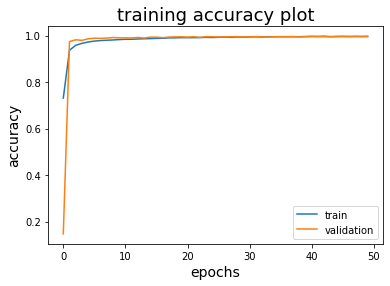

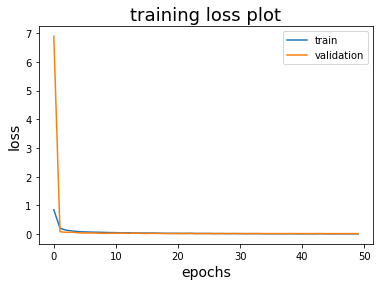

In [21]:
for metric in ['accuracy', 'loss']:
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric])
    plt.title('training '+metric+' plot', fontsize=18)
    plt.legend(['train', 'validation'])
    plt.xlabel('epochs', fontsize=14)
    plt.ylabel(metric, fontsize=14)
    plt.show()

Now we will use our model to generate predictions on the testing data and save those predictions for submission. Please note that before we can feed the test data to the model, we have to format it in the same way we did our training data. 

In [22]:
x_test_reshaped_normalized = np.array(test_data_all.copy()).astype('float64').reshape(-1, 28, 28, 1) / 255.0

print(x_test_reshaped_normalized.shape)
print(x_test_reshaped_normalized[0].dtype)

(28000, 28, 28, 1)
float64


In [23]:
x_test_predictions = model.predict(x_test_reshaped_normalized)

Let's peek at our predictions.

In [24]:
print(x_test_predictions[0])

[3.7395192e-10 1.0926772e-11 1.0000000e+00 7.6835543e-10 3.1283554e-10
 6.5770388e-12 2.7579480e-10 1.3513155e-08 3.4021766e-10 1.3134785e-10]


We see that each entry is an array of 10 numbers, corresponding to digits 0-9 in this case. Each number represents the probability that the image represents that digit. The 3rd entry has a value of 1.00, which means the first picture should be the digit 2.

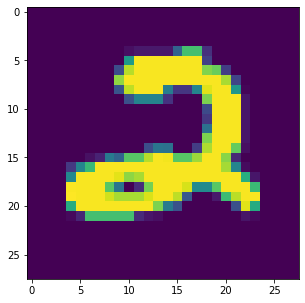

In [25]:
fig_test = plt.figure(figsize = (5, 5))
plt.imshow(x_test_reshaped_normalized[0]*255.0)
plt.show()

And we see that we are correct! Now let us save our submission.

In [26]:
submission = pd.DataFrame({'ImageId':test_data_all.index.values+1, 'Label':np.argmax(x_test_predictions, axis=1)})
submission

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


In [27]:
submission.to_csv('submission.csv', index=False)

In [28]:
%ls

__notebook__.ipynb  model.png  submission.csv


Go ahead and download the submission file and submit to the competition. Let us save our model so we may use it in the future.

In [29]:
model.save('MNIST_digit_classifier_model')

To load the model, use the following.

In [30]:
# preexisting_model = keras.models.load_model("MNIST_digit_classifier_model")

Thank you very much for checking out this notebook. If you like what you see, please give this an upvote so I can provide more content in the future! You may also follow me on twitter [@leoyuguanall38](https://twitter.com/leoyuguanall38) and [GitHub](https://github.com/leoyuguanall38).